# Speaker Recognition

Term project for Machine Learning UoT course

The objective of this Notebook is to predict the speaker of an English digit using a Keras model.

This Notebook has three main sections.
1. Extract the features of the WAV files, save them into CSV files and store them into Pandas
2. The model will be trained based on the data set created by https://github.com/Jakobovski/free-spoken-digit-dataset
3. The model will be re-trained based on the previous data plus the recordings made by Ankor (Indian accent), Caroline (Canadian female child accent) and Rodolfo (Brazilian accent)

## Section 1

The output of this section is the CSV files with the data to be handle by the model

```
trainData     : ../data/recordings/train 
testData      : ../data/recordings/test
```


In [1]:
# If true, the WAV files will be read and their features will be saved in the CSV files
# As this is the most time consuming task, only enable it if you don't have the CSV files yet
CREATE_CSV_FILES = False

In [2]:
# Defines the names of the CSV files
TRAIN_CSV_FILE = "../data/csv/train.csv"
TEST_CSV_FILE = "../data/csv/test.csv"


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import librosa
import csv
import os

def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    genres = '1 2 3 4 5 6 7 8 9 0'.split()
    for filename in os.listdir(soundFilesFolder):
        number = f'{soundFilesFolder}/{filename}'
        y, sr = librosa.load(number, mono=True, duration=30)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")

if (CREATE_CSV_FILES == True):
    extractWavFeatures("../data/recordings/trainData", TRAIN_CSV_FILE)
    extractWavFeatures("../data/recordings/testData", TEST_CSV_FILE)
    print("CSV files are created")
else:
    print("CSV files creation is skipped")

CSV files creation is skipped


In [4]:
#Reading a dataset and convert file name to corresbonding umnber

import pandas as pd
import csv
from sklearn import preprocessing

def preProcessData(csvFileName):
    print(csvFileName+ " will be preprocessed")
    data = pd.read_csv(csvFileName) # shape: 1470(0) x 28(1)
    # we have six speakers: 
    # 0: Kazanin
    # 1: Bednarsky 
    # 2: Theo
    # 3: Ankur
    # 4: Caroline
    # 5: Rodolfo
    filenameArray = data['filename'] 
    speakerArray = []
    #print(filenameArray)
    for i in range(len(filenameArray)):
        speaker = filenameArray[i][0]
        #print(speaker)
        if speaker == "k":
            speaker = 0
        elif speaker == "b":
            speaker = 1
        elif speaker == "z":
            speaker = 2
        elif speaker == "a":
            speaker = 3
        elif speaker == "c":
            speaker = 4
        elif speaker == "r":
            speaker = 5
        else: 
            speaker = 6
        #print(speaker)
        speakerArray.append(speaker)
    
    data['number'] = speakerArray
    
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape

    print("Preprocessing is finished")
    print(data.head())
    return data

trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)



../data/csv/train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.025131        2263.257195         2423.742932  5037.060547   
1  0.017434        1964.576479         2164.069455  4232.765174   
2  0.032202        1558.989634         1983.256586  3471.613770   
3  0.019922        2126.700450         2270.229736  4376.725107   
4  0.029243        1576.336568         1936.231997  3177.870117   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.114467 -416.317078   93.509689  20.108961  33.628685   
1            0.088604 -444.202728  104.891663   6.255211  39.115692   
2            0.065241 -413.475189  112.861092  22.997181  35.574394   
3            0.110794 -438.835358   95.439583  17.603657  37.666286   
4            0.066458 -397.284363  109.741707  16.604698  43.763508   

       mfcc5  ...    mfcc12     mfcc13     mfcc14    mfcc15     mfcc16  \
0   4.782962  ...  1.397505

## Section 2

There are 50 recordings for each digit for each speaker: Jackson, Nicolas and Theo (total 1500 recordings)

Training data has 49 recordings for each digit for each speaker: 1470 recordings total.
Test data has 1 recordings for each digit for each speaker: 30 recordings total.

The data used here comes from the recordings stored in:
* ../data/recordings/train
* ../data/recordings/test

The model will be trained to predict the speker of a digit.

In [5]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-1], dtype = float)
y = trainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)
print("Y from test data:", y_test.shape)

print(y_train.shape)

Y from training data: (137,)
Y from validation data: (59,)
Y from test data: (3,)
(137,)


In [6]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )

In [7]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#X_train = np.delete(X_train, len(X_train) - 1, axis = 1)
#print(X_train)
#model.summary()
print(y_val)
#Train with early stopping to avoid overfitting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=11)

139    6
113    6
16     1
75     0
154    2
185    2
69     0
55     0
18     1
169    2
156    2
15     1
161    2
60     0
115    6
114    6
145    6
9      1
73     0
187    2
112    6
93     0
138    6
45     1
85     0
67     0
128    6
173    2
30     1
68     0
82     0
119    6
183    2
24     1
137    6
95     0
56     0
19     1
122    6
76     0
5      1
65     0
136    6
97     0
168    2
123    6
165    2
12     1
35     1
162    2
42     1
66     0
135    6
78     0
118    6
124    6
29     1
132    6
170    2
Name: number, dtype: int64
Epoch 1/50
13/13 [==============================] - 3s 77ms/step - loss: 2.1399 - accuracy: 0.2190 - val_loss: 1.5317 - val_accuracy: 0.7966
Epoch 2/50
13/13 [==============================] - 0s 15ms/step - loss: 1.4777 - accuracy: 0.4818 - val_loss: 0.9500 - val_accuracy: 0.8814
Epoch 3/50
13/13 [==============================] - 0s 13ms/step - loss: 0.9774 - accuracy: 0.7372 - val_loss: 0.5117 - val_accuracy: 0.9661
Epoch 4/50
13/13 [=

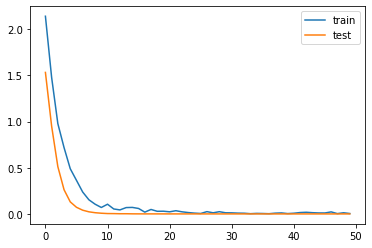

In [8]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Auxiliary functions to show the results


In [9]:
def getSpeaker(speaker):
    #speaker = str(speaker)
    if speaker == 0:
        return "Kazanin"
    elif speaker == 1:
        return "Bednarsky"
    elif speaker == 2:
        return "Zaikov"
    elif speaker == 3:
        return "Ankur"
    elif speaker == 4:
        return "Caroline"
    elif speaker == 5:
        return "Rodolfo"
    else: 
        speaker = "Unknown"
        
def printPrediction(X_data, y_data, printDigit):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        prediction = getSpeaker(np.argmax(model.predict(X_data[i:i+1]), axis=-1)[0])
        #deprecetad:  prediction = getSpeaker(model.predict_classes(X_data[i:i+1])[0])

        speaker = getSpeaker(y_data[i])
        if printDigit == True:
            print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
            print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))

In [10]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

def report(X_data, y_data):
    #Confution Matrix and Classification Report
    Y_pred = model.predict_classes(X_data)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    target_names = ["Jackson", "Nicola", "Theo", "Ankur", "Caroline", "Rodolfo", "Unknown"]
    print(classification_report(y_test_num, Y_pred))


### Проверяем на тестовом датасете

In [11]:
print('\n# TEST DATA #\n')
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
printPrediction(X_test[0:100], y_test[0:100], False)


# TEST DATA #

1/1 [==============================] - 0s 88ms/step - loss: 4.1063 - accuracy: 0.6667
accuracy: 66.67%

# Generate predictions
1/1 [==============================] - 0s 282ms/step
y=Bednarsky - prediction=Bednarsky - match=True
1/1 [==============================] - 0s 57ms/step
y=Kazanin   - prediction=Zaikov    - match=False
1/1 [==============================] - 0s 64ms/step
y=Zaikov    - prediction=Zaikov    - match=True
